In [1]:
# Python Free Fermion Large Scale Simulation Platform (PyFerm) Demos
# Author: Bill Zhai pzhai@g.harvard.edu
# PI: Susanne F. Yelin
# Nov 30, 2022

In [2]:
# My PyFerm modules:
from Utils_torch_version import Network, get_nn_pairs, binary_basis, unpacknbits, initialize_sparse

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import scipy.linalg
import time
import torch # PyTorch is required for this demo
import math
import qiskit # Qiskit is required for this demo

# Example 2: Compare Runtimes

In this demo, we compare the runtimes of the free Fermion simulation versus the exact diagonalization simulation, on the same continuous Hamiltonian evolution as in Demo 1:

$\begin{equation}
    \begin{aligned}
        \mathcal{H}_{Pauli} &=b_{i i} a_i^{\dagger} a_i+b_{j j} a_j^{\dagger} a_j+(c+di) a_i^{\dagger} a_j+(c-di) a_j^{\dagger} a_i \\ &= -\frac{1}{2} \left(b_{ii} Z_i + b_{jj} Z_j\right)+\frac{c}{2} \left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j + X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j \right)\\
        &+\frac{d}{2}\left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j - X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j \right),
    \end{aligned}
\end{equation}$

which is mapped to the Fermionic algebra as:

$\begin{equation}
\mathcal{H}_{Fermi}=b_{i i} a_i^{\dagger} a_i+b_{j j} a_j^{\dagger} a_j+b_{i j} a_i^{\dagger} a_j+b_{i j}^* a_j^{\dagger} a_i.
\end{equation}$

We conduct the runtime comparison with the following benchmarking procedure (N is the number of qubits in the system):

Set x_input state as a simple product state (in this case we use 101010...10).

For N in [2,4,6,8,10]:



1. Evolve the initial state by $e^{-i\mathcal{H}t}$ to a final state $|\psi_{f}\rangle$, where we pick $i,j$ as the first and last qubit.

2. Calculating the probability of observing bit string 101010...10, which is $p(y=101010|x=101010)=|\langle1010...10| e^{-i\mathcal{H}t}|101010...10\rangle|^2$

3. Record and compare the time to get $p(y=101010|x=101010)$ for Fermion simulation and for exact diagonalization

In [3]:

Ns = [2, 4, 6, 8, 10]
reps = 5
avg_time_at_N_fermion, avg_time_at_N_exact = [], []
std_time_at_N_fermion, std_time_at_N_exact = [], []
avg_abs_diff_prob_at_N, std_abs_diff_prob_at_N = [], []

for N in Ns:
    print('start N: ', N)
    conn_list = [ [0, N-1] ] # zero indexed and should not be periodic (not a closed circle)
    times_fermion = []
    times_exact = []
    diffs = [] # to collect the differences between two simulation methods
    for rep in range(reps):
        L = len(conn_list) # Number of layers
        # initiliaze the evolution
        evolution = Network(conn_list, N)
        
        # The 1010101... basis state as input
        x = torch.tensor([ [1,0]*int(N/2) ]) if N%2==0 else torch.tensor([[1,0]*int(N/2)+[1]])  
        
        # Create statevector for ED
        x_string = '10'*int(N/2)+'1' if N%2==1 else '10'*int(N/2)
        init_state_numpy = qiskit.quantum_info.Statevector.from_label(x_string).data

        # Fix this, the parameters are defined differently now for the pytorch implementation
        params_m = torch.tensor(math.pi) * torch.rand((L, 4))
        
        t = 1.5 # Time to evolve the state for. Can set to other arbitrary values
        evolution.manual_set_params(t*params_m) # load parameterse to the evolution

        #basis_m_n = torch.tensor(binary_basis(geometry=(N,)))

        probs = torch.zeros(2**(N), dtype=torch.cfloat)
        ts = time.time()
        
        y = x # Calculate the probability of observing 101010... Can choose other bit strings too
        # A mask that tells the network which qubits to measure in the end
        # Eg. 11111 means measuring all qubits, 11000, means measurin the first two qubits
        sub_mask = torch.tensor([ [1]*N ])
        
        # Since we aren't doing optimization, simply record the numerical value, detach gradients.
        probs_fermion = \
            evolution.forward_partial_observation(y, x, sub_mask).detach().numpy()
        
        # Record the Fermion simulation's runtime
        tf = time.time()
        times_fermion.append(tf - ts)

        ts = time.time() # Reset timer
        
        # Calculate the evolution matrix e^{-iHt}
        exp_iH_exact = np.eye(2**N)
        for l in range(L):
            conn = conn_list[l]
            a, b, c, d = params_m.detach().numpy()[l]
            H_exact = initialize_sparse(N, conn[0], conn[1], a, b, c, d)
            exp_iH_exact = (scipy.linalg.expm(-t*1.0j*H_exact))@exp_iH_exact # 1.0j or -1.0j?
        
        # Exact final state via ED
        state_exact = np.matmul(exp_iH_exact, init_state_numpy[:,None])
        
        ind = int(''.join([str(i) for i in y.detach().numpy().squeeze()]), 2) 
        # The measurement probabilities calculated via ED:
        probs_exact = (np.abs(state_exact[ind])**2).squeeze()
        tf = time.time()
        times_exact.append(tf - ts)

        diff = probs_fermion-probs_exact
        diffs.append(np.abs(diff))
        # See if two simulations agree:
#         print('Fermion_prob, ED_prob, difference', (probs_fermion, probs_exact, diff))

    avg_time_fermion = sum(times_fermion)/reps
    std_time_fermion = np.std(times_fermion)

    avg_time_exact = sum(times_exact)/reps
    std_time_exact = np.std(times_exact)


    avg_time_at_N_fermion.append(avg_time_fermion)
    avg_time_at_N_exact.append(avg_time_exact)
    
    std_time_at_N_fermion.append(std_time_fermion)
    std_time_at_N_exact.append(std_time_exact)
    
    avg_abs_diff_prob_at_N.append(np.mean(diffs))
    std_abs_diff_prob_at_N.append(np.std(diffs))

start N:  2
start N:  4
start N:  6
start N:  8
start N:  10


avg_time_at_N_fermion [0.00135241 0.00093579 0.00135994 0.00111442 0.00131001]
avg_time_at_N_exact [0.01087942 0.01485338 0.03921499 0.083636   1.01904249]


Text(0.5, 0, 'diff in probs')

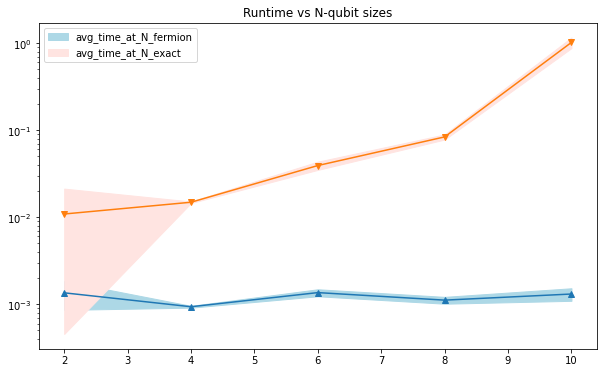

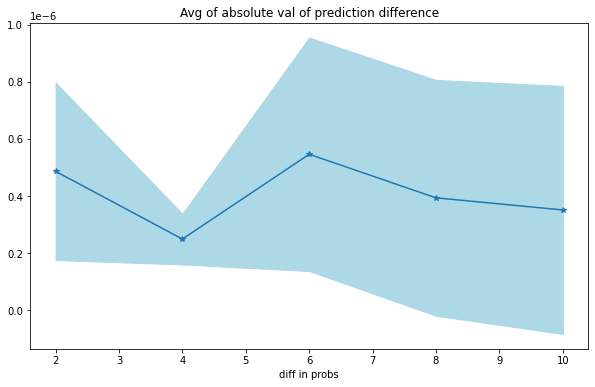

In [4]:
avg_time_at_N_fermion = np.array(avg_time_at_N_fermion)
avg_time_at_N_exact = np.array(avg_time_at_N_exact)

std_time_at_N_fermion = np.array(std_time_at_N_fermion)
std_time_at_N_exact = np.array(std_time_at_N_exact)
    
avg_abs_diff_prob_at_N = np.array(avg_abs_diff_prob_at_N)
std_abs_diff_prob_at_N = np.array(std_abs_diff_prob_at_N)
    
print('avg_time_at_N_fermion', avg_time_at_N_fermion)
print('avg_time_at_N_exact', avg_time_at_N_exact)

plt.figure(figsize=(10, 6))
plt.fill_between(Ns, avg_time_at_N_fermion-std_time_at_N_fermion, \
                     avg_time_at_N_fermion+std_time_at_N_fermion, color='lightblue')

# plt.plot(Ns, avg_time_at_N_exact+std_time_exact, '^')
# plt.plot(Ns, avg_time_at_N_exact-std_time_exact, 'v')
plt.fill_between(Ns, avg_time_at_N_exact-std_time_at_N_exact, \
                     avg_time_at_N_exact+std_time_at_N_exact, color='mistyrose')

plt.plot(Ns, avg_time_at_N_fermion, "^-")
plt.plot(Ns, avg_time_at_N_exact, "v-")
plt.legend(['avg_time_at_N_fermion', 'avg_time_at_N_exact'])
plt.title('Runtime vs N-qubit sizes')
plt.yscale('log')

plt.figure(figsize=(10, 6))
plt.fill_between(Ns, avg_abs_diff_prob_at_N-std_abs_diff_prob_at_N, \
                 avg_abs_diff_prob_at_N+std_abs_diff_prob_at_N, color='lightblue')
plt.plot(Ns, avg_abs_diff_prob_at_N, '*-')
plt.title('Avg of absolute val of prediction difference')
plt.xlabel('number of qubits')
plt.xlabel('diff in probs')